# Gravitational Waves detection

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import h5py
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

I read a dataset containing simulated gravitational-wave signals from merging black holes, through the package *h5py*.

In [2]:
dataset = h5py.File('sample_2e7_design_precessing_higherordermodes_3detectors.h5', 'r')

In [3]:
list(dataset.keys())

['chi1x',
 'chi1y',
 'chi1z',
 'chi2x',
 'chi2y',
 'chi2z',
 'dec',
 'default',
 'det',
 'iota',
 'mtot',
 'psi',
 'q',
 'ra',
 'snr',
 'z']

Since the data is very heavy, i can do a downsample, in order to increase the speed of computations.

In [107]:
mtot = dataset['mtot'][:1000]
q = dataset['q'][:1000]
z = dataset['z'][:1000]
det = dataset['det'][:1000]
snr = dataset['snr'][:1000]
iota = dataset['iota'][:1000]
psi = dataset['psi'][:1000]
ra = dataset['ra'][:1000]
dec = dataset['dec'][:1000]

I explore some of the variables.

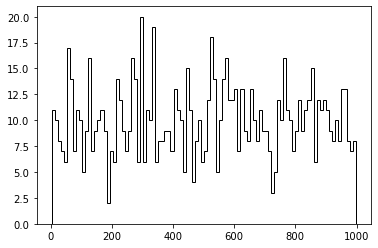

In [5]:
plt.hist(mtot, histtype = 'step', color = 'k', bins=100);

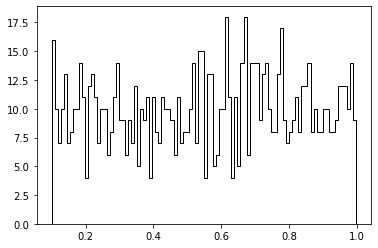

In [6]:
plt.hist(q, histtype = 'step', color = 'k', bins=100);

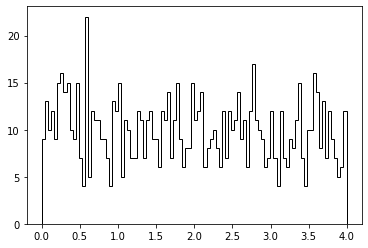

In [7]:
plt.hist(z, histtype = 'step', color = 'k', bins=100);

I run now a classifier on the variable *det*, an array of 0s and 1s, which respectively tell me if a source is detectable (SNR > 12) or not (SNR < 12).

**Decision Tree Classifier**

In [8]:
# i take the total mass and the redshift
X = np.hstack([mtot[:, np.newaxis], z[:, np.newaxis]])
y = det

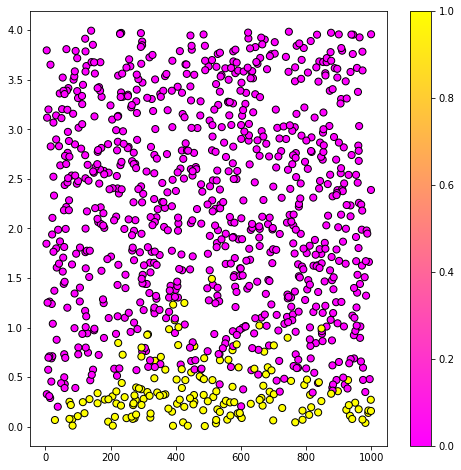

In [9]:
fig = plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='spring', edgecolor='k')
plt.show();

I run a Cross-Validation in order to take the best depth parameter to give to the Decision Tree Classifier.

In [10]:
from sklearn.model_selection import GridSearchCV

clf = DecisionTreeClassifier()
drange = np.arange(1,21)  #Complete

grid = GridSearchCV(clf, param_grid={'max_depth': drange}, cv=5) #Complete
grid.fit(X, y)

best = grid.best_params_['max_depth']
print("best parameter choice:", best)

best parameter choice: 4


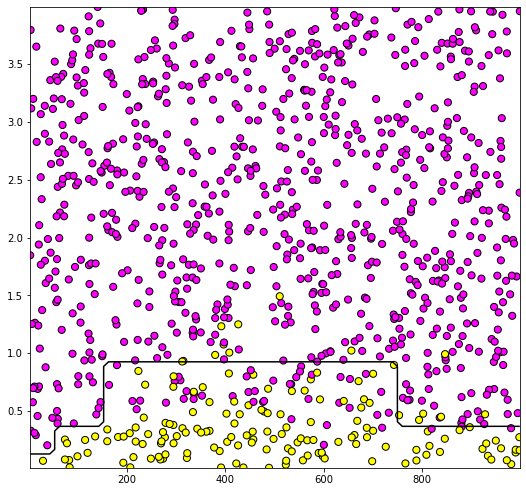

In [11]:
dt = DecisionTreeClassifier(random_state=0, max_depth=best, 
                            criterion='entropy')
dt.fit(X, y)
yprob = dt.predict_proba(X) # If we wanted probabilities rather than the discrete classes

#xlim = (0, 1)
#ylim = (-1, 5)
xlim = (np.min(X[:, 0]), np.max(X[:, 0])) 
ylim = (np.min(X[:, 1]), np.max(X[:, 1]))


xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 51),
                     np.linspace(ylim[0], ylim[1], 51))
xystack = np.vstack([xx.ravel(),yy.ravel()])
Xgrid = xystack.T

Z = dt.predict(Xgrid)
Z = Z.reshape(xx.shape)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(111)
im = ax.scatter(X[:, 0], X[:, 1], c=y, s=50, 
                cmap=plt.cm.spring, zorder=2, edgecolor='k')

ax.contour(xx, yy, Z, [0.5], colors='k')
plt.show()

The result is nice, bu i can try to improve it with **bagging**.

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [13]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

y_pred_tree = tree_clf.predict(X_test)

In [14]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), 
    n_estimators=500, max_samples=100, 
    bootstrap=True, random_state=42, n_jobs=-1)

%timeit bag_clf.fit(X_train, y_train)

y_pred_bag = bag_clf.predict(X_test)

488 ms ± 48.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
print("With bagging, the accuracy results to be: " + str(accuracy_score(y_test, y_pred_bag)))
print("Without bagging, the accuracy results to be: " + str(accuracy_score(y_test, y_pred_tree)))

With bagging, the accuracy results to be: 0.968
Without bagging, the accuracy results to be: 0.936


The accuracies tell me that with bagging, the classifier performs slightly better. But let's plot the decision boundary and the full result.

In [16]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[np.min(X[:, 0]), np.max(X[:, 0]), 
                                            np.min(X[:, 1]), np.max(X[:, 1])], 
                           alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], 
             "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], 
             "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

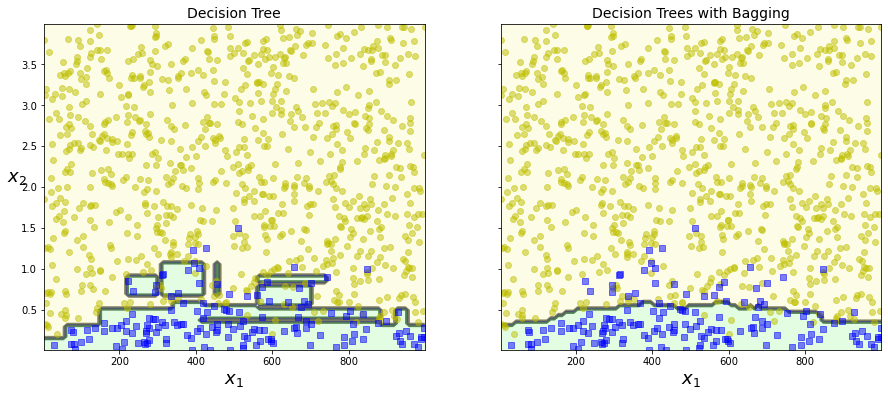

In [17]:
fix, axes = plt.subplots(ncols=2, figsize=(15,6), sharey=True)

plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)

plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)

plt.ylabel("")
plt.show()

This is already a better result, but it can be seen that some sporadic points are completely ignored by bagging. 

I can now try with another classifier: the **Random Forest Classifier**

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
n = np.arange(10, 201, 10)

grid = GridSearchCV(clf, param_grid={'n_estimators': n}, cv=5)
grid.fit(X, y)

best = grid.best_params_['n_estimators']
print("best parameter choice:", best)

best parameter choice: 60


In [19]:
ranfor = RandomForestClassifier(20)
ranfor.fit(X,y)

y_pred = ranfor.predict(X)

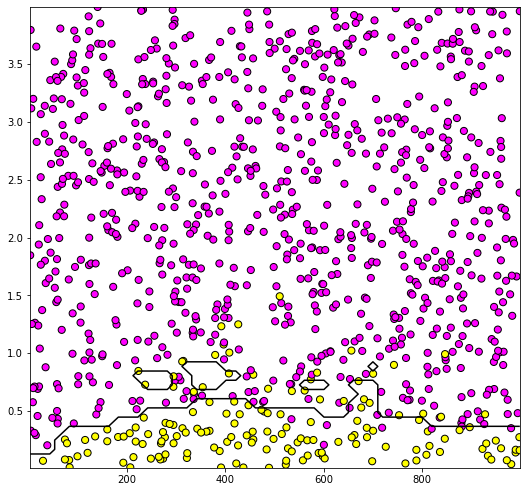

In [20]:
dt = RandomForestClassifier(random_state=0, n_estimators=best, 
                            criterion='gini')
dt.fit(X, y)
yprob = dt.predict_proba(X) # If we wanted probabilities rather than the discrete classes

#xlim = (0, 1)
#ylim = (-1, 5)
xlim = (np.min(X[:, 0]), np.max(X[:, 0])) 
ylim = (np.min(X[:, 1]), np.max(X[:, 1]))


xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 51),
                     np.linspace(ylim[0], ylim[1], 51))
xystack = np.vstack([xx.ravel(),yy.ravel()])
Xgrid = xystack.T

Z = dt.predict(Xgrid)
Z = Z.reshape(xx.shape)

#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0,
                    left=0.1, right=0.95, wspace=0.2)

# left plot: data and decision boundary
ax = fig.add_subplot(111)
im = ax.scatter(X[:, 0], X[:, 1], c=y, s=50, 
                cmap=plt.cm.spring, zorder=2, edgecolor='k')

ax.contour(xx, yy, Z, [0.5], colors='k')
plt.show()

Here i already notice that, in respect to the Decision Tree Classifier, the Random Forest draws a more precise decision boundary.

**Random Forest with bagging**

In [21]:
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train, y_train)

y_pred_forest = tree_clf.predict(X_test)

In [25]:
bag_clf_forest = BaggingClassifier(
    RandomForestClassifier(random_state=42), 
    n_estimators=50, max_samples=100, 
    bootstrap=True, random_state=42, n_jobs=-1)  # or n_jobs = -1 for full CPU usage

%timeit bag_clf_forest.fit(X_train, y_train)

y_pred_bag_forest = bag_clf_forest.predict(X_test)

3.19 s ± 228 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
print("With bagging, the accuracy results to be: " + str(accuracy_score(y_test, y_pred_bag_forest)))
print("Without bagging, the accuracy results to be: " + str(accuracy_score(y_test, y_pred_forest)))

With bagging, the accuracy results to be: 0.972
Without bagging, the accuracy results to be: 0.936


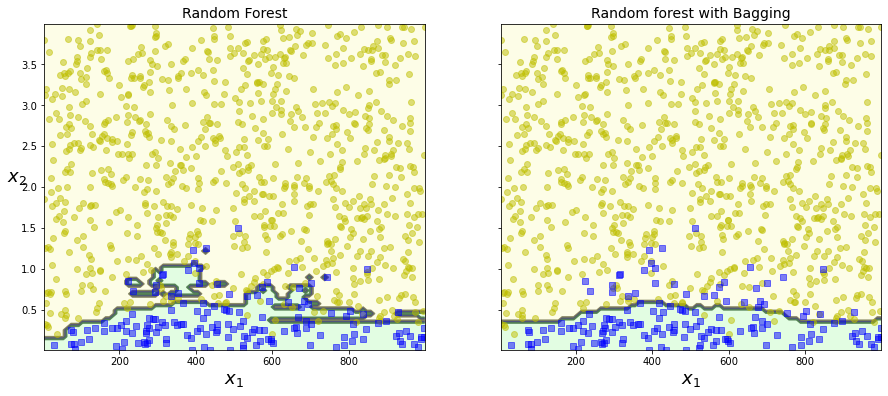

In [27]:
fix, axes = plt.subplots(ncols=2, figsize=(15,6), sharey=True)

plt.sca(axes[0])
plot_decision_boundary(forest_clf, X, y)
plt.title("Random Forest", fontsize=14)

plt.sca(axes[1])
plot_decision_boundary(bag_clf_forest, X, y)
plt.title("Random forest with Bagging", fontsize=14)

plt.ylabel("")
plt.show()

Also here the upper points seem to be completely ignored by bagging.

In [ ]:
### RERUN THIS WITH LESS N_ESTIMATORS MAYBE ###

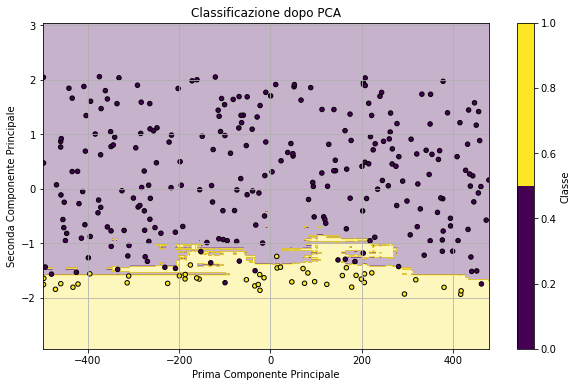

In [117]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X = np.hstack([mtot[:, np.newaxis], z[:, np.newaxis]])
y = det

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)


plt.figure(figsize=(10, 6))

# Decision boundary
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.get_cmap('viridis', len(np.unique(y))))

# Plot
scatter = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap=plt.get_cmap('viridis', len(np.unique(y))), edgecolor='k', s=20)
plt.colorbar(scatter, label='SNR')
plt.xlabel('Principal Component 0')
plt.ylabel('Principal Component 1')
plt.title('Classification after PCA')
plt.grid(True)
plt.show()